# OSM 2018 Economics
## Problem Set 6
### 07.30.2018 
### Yung-Hsu Tsui*
* I thank Timothy Munday for his great help.

In [17]:
import numpy as np
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like #importing pandas_datareader gives me an error without this line
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import datetime
from scipy import optimize as opt

### Exercise 2

In [18]:
def convert_to_daily_with_ffill(df):
    '''convert_to_daily_with_ffill

    This method converts a dataframe to have a daily index and forward fills all of the missing days.  Useful for converting (for example) stock market data to quarterly data when the quarterly return is wanted.

    :param df: a pandas.DataFrame to be converted
    :returns: a pandas.DataFrame that has been converted
    '''

    new_idx = pd.date_range('01-01-1950', '07-01-2018')
    df = df.reindex(new_idx)
    df = df.fillna(method="ffill")
    return df

start = datetime.datetime(1950, 1,1)
end = datetime.datetime(2018, 7, 1)
rpce = web.DataReader('PCECC96', 'fred', start, end)
w5000 = web.DataReader('WILL5000INDFC', 'fred', start, end)
w5000 = convert_to_daily_with_ffill(w5000)
gdef = web.DataReader('GDPDEF', 'fred', start, end)
tb = web.DataReader('TB3MS', 'fred', start, end)

df = pd.DataFrame(columns=['rpce', 'w5000', 'tb', 'gdef'], index = rpce.index)
df['rpce'] = rpce
df['w5000'] = w5000
df['gdef'] = gdef
df['inf'] = df['gdef']/df['gdef'].shift(1)
#df['w5000_d'] = df['w5000']/df['inf']      # Deflated asset price returns
df['R_nom'] = df['w5000'].shift(-1)/df['w5000']
df['R'] = df['R_nom']/df['inf']# Returns to asset prices
df['tb'] = tb/100. + 1    # Convert to percentage and make a gross return
df['rpce_1'] = rpce.shift(-1)
df  = df.dropna(axis=0)   # Drop NaNs
df.head(10)

,rpce,w5000,tb,gdef,inf,R_nom,R,rpce_1
DATE,,,,,,,,
1971-01-01,3156.978,1.00,1.0444,22.391,1.015189,1.120000,1.103243,3185.993
1971-04-01,3185.993,1.12,1.0386,22.685,1.013130,1.008929,0.995853,3211.394
1971-07-01,3211.394,1.13,1.0540,22.916,1.010183,0.991150,0.981159,3264.679
1971-10-01,3264.679,1.12,1.0446,23.107,1.008335,1.053571,1.044863,3307.767
1972-01-01,3307.767,1.18,1.0338,23.458,1.015190,1.067797,1.051819,3370.736
1972-04-01,3370.736,1.26,1.0371,23.604,1.006224,1.007937,1.001702,3422.682
1972-07-01,3422.682,1.27,1.0398,23.830,1.009575,1.023622,1.013914,3503.001
1972-10-01,3503.001,1.30,1.0474,24.134,1.012757,1.069231,1.055762,3566.957
1973-01-01,3566.957,1.39,1.0541,24.412,1.011519,0.920863,0.910377,3565.349


In [38]:
def sdf(gamma):
    m_tp1 = 0.99*(df['rpce_1']**(-gamma))/(df['rpce']**(-gamma))
    return m_tp1

def err_1(gamma):
    cov = sdf(gamma).cov(df['R'])
    error = 1 - cov - (sdf(gamma).mean())*(df['R'].mean())
    return error

print(opt.root(err_1, 1.0).success, 'gamma =', opt.root(err_1, 1.0).x)

True gamma = [ 1.37995685]


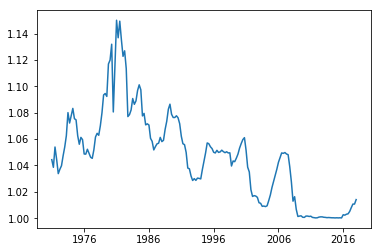

In [20]:
plt.plot(df['tb'])

In [39]:
def err_3(gamma):
    error = df['tb'] - 1/sdf(gamma)
    errorabs = np.abs(error)
    dist = errorabs.sum()
    return dist
a = opt.minimize(err_3, 0.8, method = 'L-BFGS-B')
print(a.success, a.x)

True [ 2.78201787]


In [46]:
def sdf(gamma, beta):
    m_tp1 = beta*(df['rpce_1']**(-gamma))/(df['rpce']**(-gamma))
    return m_tp1

def err_4_1(params):
    gamma, beta = params
    cov = sdf(gamma, beta).cov(df['R'])
    error_1 = 1 - cov - (sdf(gamma, beta).mean())*(df['R'].mean())
    
    error_temp = df['tb'] - 1/sdf(gamma, beta)
    errorabs = np.abs(error_temp)
    error_2 = errorabs.sum()
    
    error = np.zeros(2)
    error[0] = error_1
    error[1] = error_2
    
    return error

In [47]:
def criterion(params, *args):
    gamma, beta = params
    W = args
    error = err_4_1(params)
    crit_val = error.T @ W @ error
    return crit_val

In [48]:
W_4 = np.eye(2)
params_init = np.array([5, 0.5])
gmm_args = W_4

In [50]:
b = opt.minimize(criterion, params_init, args = gmm_args, method = 'L-BFGS-B', bounds = ((1e-10, None), (1e-10, 1)))
print(b.success, b.x)

True [ 0.1063835   0.95419882]


In [51]:
n = 60
N = 5
gamma_grid = np.linspace(0, 5, n)
beta_grid = np.linspace(0.95, 0.99, N)
gmm_values = np.zeros((n, N))
for i in range(n):
    for j in range(N):
        gmm_values[i, j] = criterion((gamma_grid[i], beta_grid[j]), W_4)

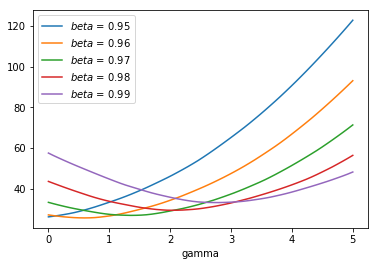

In [52]:
for j in range(N):
    plt.plot(gamma_grid, gmm_values[:, j], label=rf'$beta$ = {beta_grid[j]:.2f}')
plt.xlabel('gamma')
plt.legend()
plt.show()

### Exercise 3

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint as pprint
import scipy.stats as sts
import pickle
import statsmodels.formula.api as smf
import statsmodels.api as sm
import datetime

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [61]:
# Loading Data
AAPL = np.load('AAPL.txt')
C = np.load('C.txt')
THO = np.load('THO.txt')
GBX = np.load('GBX.txt')
SPY = np.load('SPY.txt')

In [62]:
class Orderbook:
    '''
    The orderbook class. Initialized with a single element of the raw data files.
    Methods:
        __init__: accepts the raw data and a name and cleans it up - the final form 
            is a dataframe with columns for price, quantity at that price, cumulative 
            quantity, and buy/sell side.
        estimate: estimates parameters γ and β for equation (10). I have two different 
            estimators, which limit the regression to subsets of the data only inculding bids
            within 10 pct and 5 pct of the observations
        plot: plots the orderbook with the two estimatorsoverlaid in the 15 pct region
    '''
    
    def __init__(self, data, name):
        self.ticker = data[0]
        self.name = name
        
        #Converting raw data into prices and quantities
        df = pd.DataFrame.from_dict(data[1], orient='index')
        df = df.sort_index()
        df = df.reset_index()
        df.columns = ['Price', 'Quantity', 'Side', 'X','Y']
        df = df.drop(['X', 'Y'], axis = 1)
        
        #Get cumulative quantity - setting 0 to where buy meets sell
        df['Cumulative_Quantity'] = df['Quantity'].cumsum()
        Qmkt = np.max(df['Cumulative_Quantity'][df['Side']== 'B'])
        Pmkt = df['Price'][(df['Cumulative_Quantity'][df['Side']== 'B']).idxmax()]
        df['Cumulative_Quantity'] = df['Cumulative_Quantity'] - Qmkt
        # Save Price as attribute
        self.Pmkt = Pmkt
        
        #Restrict to region where most of the quantity moves
        
        #Save data and some subsets as attributes
        self.data = df
        self.data10P = df[(df.Price >= self.Pmkt*.90) 
                               & (df.Price <= self.Pmkt*1.10)]
        self.data05P = df[(df.Price >= self.Pmkt*.95) 
                               & (df.Price <= self.Pmkt*1.05)]

        
    def estimate(self, orderbook):
        result = smf.ols(formula='Cumulative_Quantity ~ Price', data=orderbook).fit()
        gamma, beta = result.params[0], result.params[1]
        return result.params
    
    def plot(self):
        #Plot orderbook
        plt.plot(self.data10P['Price'], self.data10P['Cumulative_Quantity'],\
                 label = 'Orderbook')
        
        #Get 2 different estimators
        
        result05P = self.estimate(self.data05P)
        gamma05P, beta05P = result05P[0], result05P[1]
        est05P = gamma05P + beta05P * self.data10P.Price
        
        result10P = self.estimate(self.data10P)
        gamma10P, beta10P = result10P[0], result10P[1]
        est10P = gamma10P + beta10P * self.data10P.Price
        
        #Plot estimators
        plt.plot(self.data10P.Price, est10P, label = f'Approximation within 10% of P \n \
 \n γ = {np.round(gamma10P)} \n β = {np.round(beta10P)}')
        plt.plot(self.data10P.Price, est05P, label = f'Approximation within 5% of P \n γ = {np.round(gamma05P)} \
\n β = {np.round(beta05P)}')
        plt.legend(loc = 'center left', bbox_to_anchor = (0, .8))
        plt.title(f'Order Book of {self.name} at time {self.ticker}')
        plt.xlabel('Price')
        plt.ylabel('Cumulative Quantity')
        plt.xlim(self.data10P.Price.min(), self.data10P.Price.max())
        plt.ylim(self.data10P.Cumulative_Quantity.min() * 1.1, self.data10P.Cumulative_Quantity.max() * 1.1)

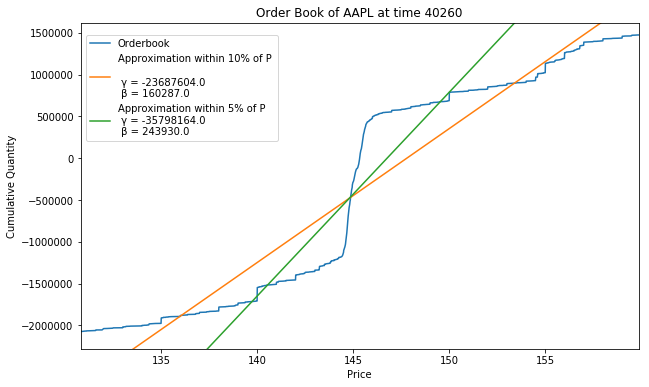

In [63]:
book = Orderbook(AAPL[100], 'AAPL')
fig = plt.subplots(figsize = (10, 6))
book.plot()

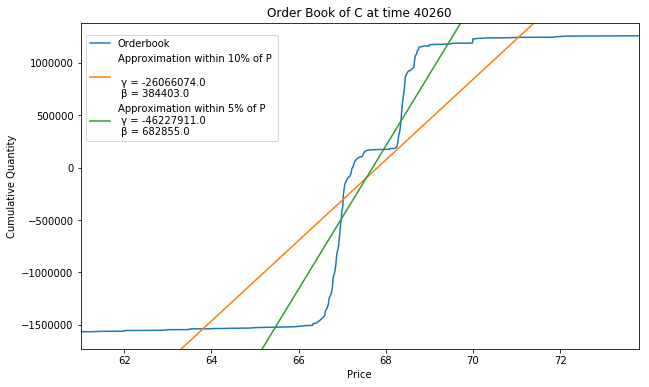

In [64]:
book = Orderbook(C[100], 'C')
fig = plt.subplots(figsize = (10, 6))
book.plot()

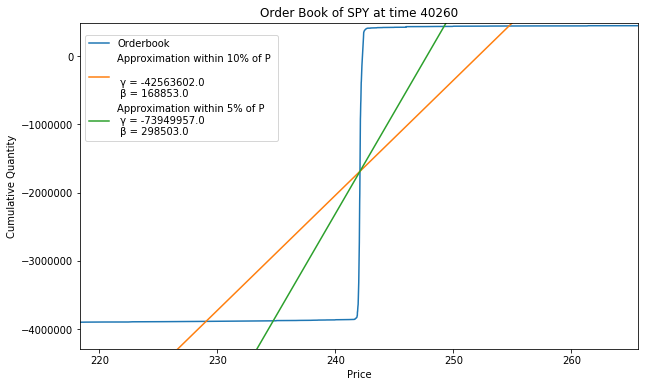

In [65]:
book = Orderbook(SPY[100], 'SPY')
fig = plt.subplots(figsize = (10, 6))
book.plot()

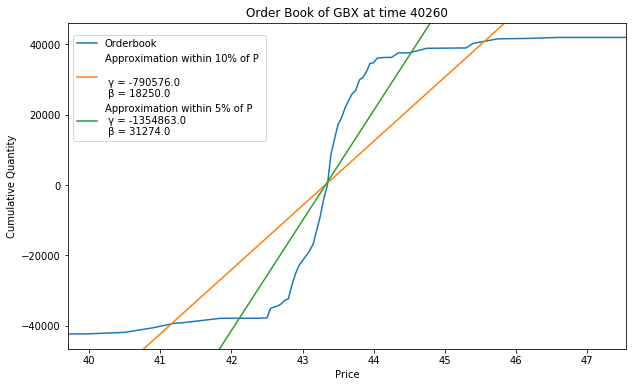

In [66]:
book = Orderbook(GBX[100], 'GBX')
fig = plt.subplots(figsize = (10, 6))
book.plot()

In [67]:
class Assetday():
    '''
    This class is initialized with a raw data dictionary from the NASDAQ ITCH files,
    cleans the data into individual data-frames and is equipped with some nice plotting 
    methods which span the whole day.
    Methods:
        init:
            initializes data series for the ticker. Accepts raw data and a name which is 
            printed on the graphs. Create series for times, market price, and ratio/imputed 
            price for each estimate. 
        signoiseplot:
            Plots time series of noise/signal estimators for each estimator
        priceestplot: 
            Plots market price and price estimators over time
    '''
    
    def __init__(self, rawdata, name):
        #Initialize attributes
        self.prices = []
        self.times = []
        self.ratio05Ps = []
        self.ratio10Ps = []
        self.Pimputed05s = []
        self.Pimputed10s = []
        self.name = name
        for i in range(len(rawdata)):
            book = Orderbook(rawdata[i], name)
            
            #Get ratios and imputed prices
            result05P = book.estimate(book.data05P)
            gamma05P, beta05P = result05P[0], result05P[1]
            Pimputed05 = -gamma05P / beta05P 
            
            result10P = book.estimate(book.data10P)
            gamma10P, beta10P = result10P[0], result10P[1]
            Pimputed10 = -gamma10P / beta10P
            
            self.prices.append(book.Pmkt)
            self.times.append(book.ticker)
            self.ratio05Ps.append(beta05P)
            self.ratio10Ps.append(beta10P)
            self.Pimputed05s.append(Pimputed05)
            self.Pimputed10s.append(Pimputed10)
            
    def signoiseplot(self):
        fig = plt.subplots(figsize = (10, 6))
        plt.plot(self.times, self.ratio05Ps, label = 'Approximation Within 5 Pct of P')
        plt.plot(self.times, self.ratio10Ps, label = 'Approximation Within 10 Pct of P')
        plt.xlabel('Time (seconds after midnight)')
        plt.ylabel('Noise/Signal Ratio')
        plt.legend(loc = 'center left', bbox_to_anchor = (0, .9))
        plt.title(f'Market Maker Beliefs About Composition of Investor Pool Over Time for {self.name}')
        
    def priceestplot(self):
        fig = plt.subplots(figsize = (10, 6))
        plt.plot(self.times, self.prices, label = 'Market Price')
        plt.plot(self.times, self.Pimputed10s, label = 'Imputed price - Within 10% of P')
        plt.plot(self.times, self.Pimputed05s, label = 'Imputed price - Within 5% of P')
        plt.xlabel('Time (seconds after midnight)')
        plt.ylabel('Price (USD)')
        plt.legend(loc = 'center left', bbox_to_anchor = (0, .9))
        plt.title(f'Comparison of Model-Imputed price and actual price for {self.name}')

In [68]:
AAPLAD = Assetday(AAPL, 'AAPL')
CAD = Assetday(C, 'C')
SPYAD = Assetday(SPY, 'SPY')
GBXAD = Assetday(GBX, 'GBX')
THOAD = Assetday(THO, 'THO')

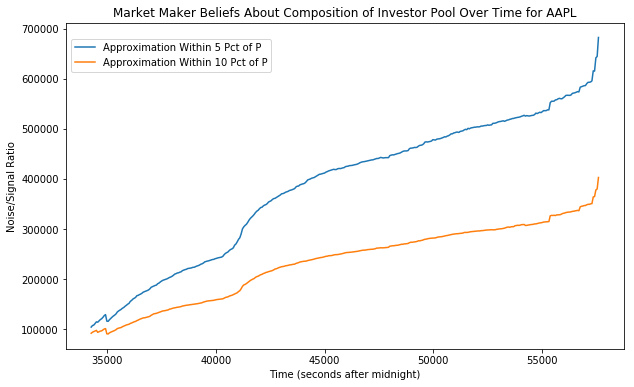

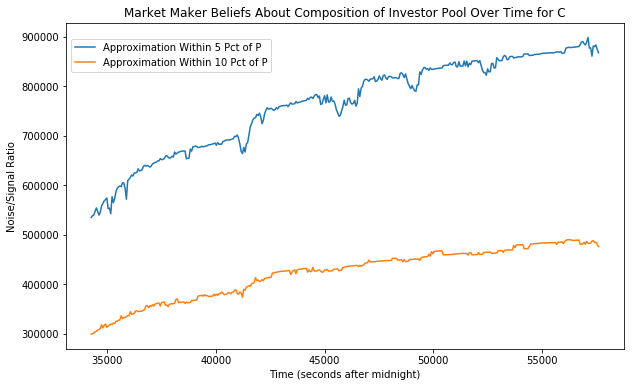

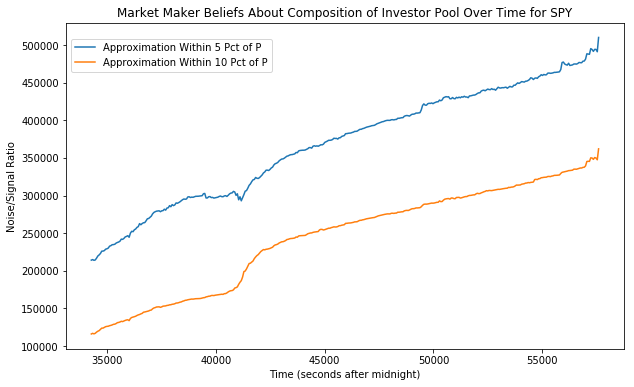

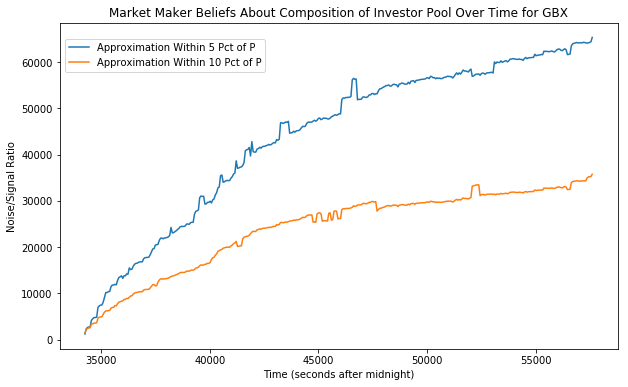

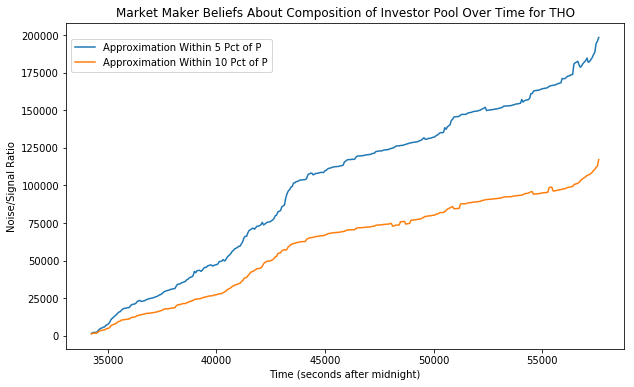

In [75]:
AAPLAD.signoiseplot()
CAD.signoiseplot()
SPYAD.signoiseplot()
GBXAD.signoiseplot()
THOAD.signoiseplot()

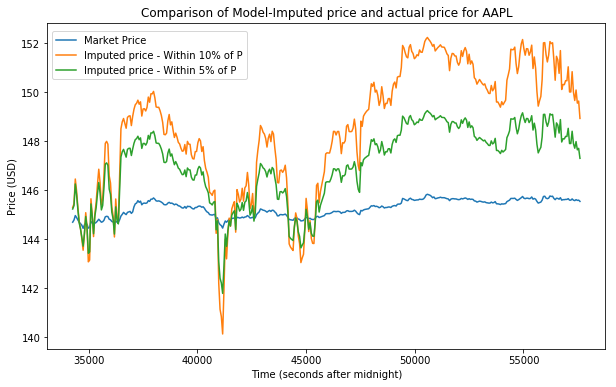

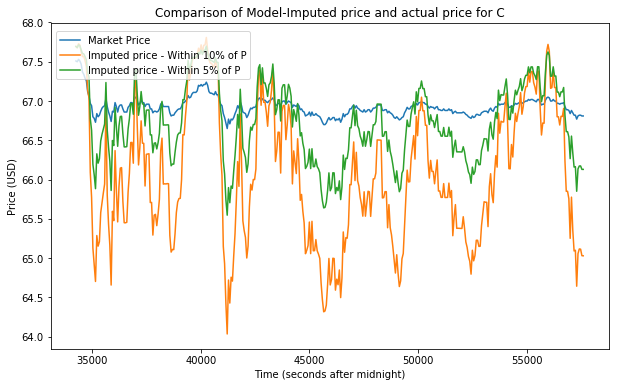

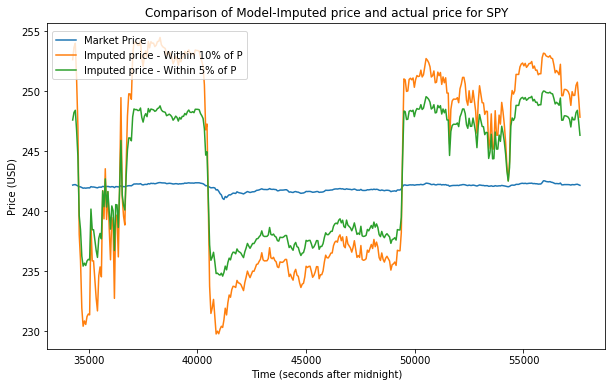

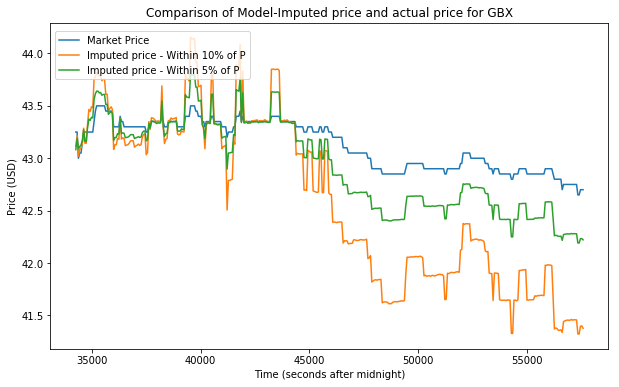

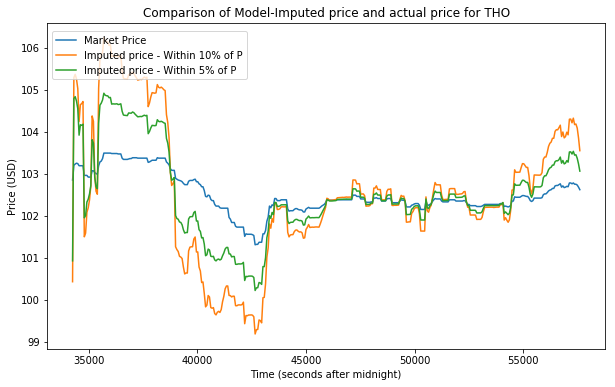

In [74]:
AAPLAD.priceestplot()
CAD.priceestplot()
SPYAD.priceestplot()
GBXAD.priceestplot()
THOAD.priceestplot()
